This notebook shows an example using a big patient encounters dataset and how the functions can be used to quickly extract feature vectors for prediction.

For this example, the first occurrence of an injury will be identified. Then the history before the first injury will be utilized to predict whether a second occurrence of it will happen in the future.

Note: this model is not expected to perform well due to the data being randomly generated.

In [1]:
%matplotlib inline
import pandas as pd

Load the data

In [2]:
df = pd.read_csv('data/encounters.csv')
df['EncounterDate'] = pd.to_datetime(df['EncounterDate'])
df.shape

(8395, 8)

In [3]:
df.head()

,PatientID,PatientAge,PatientGender,PatientCategory,EncounterDate,Diagnosis1,Diagnosis2,Diagnosis3
0,1,31,M,C,2015-08-14,AA,AC,CC
1,1,33,M,C,2017-12-01,AC,AC,BC
2,1,35,M,C,2019-03-12,BB,AC,CB
3,1,33,M,C,2017-12-12,BC,BC,CC
4,1,34,M,C,2018-03-15,CA,BB,AB


Find out how many patients are in this dataset.

In [4]:
df['PatientID'].nunique()

1000

We will be looking for the injury coded as `AB` and the first occurrence of it.

In [5]:
from ehr_functions.features import codes
df_injury = codes.get_nth_occurrence(df, 'AB')
df_injury.head()

,PatientID,EncounterDate
0,1,2016-10-19
1,2,2018-07-19
2,3,2018-03-14
3,4,2016-01-01
4,5,2019-08-30


Check how many patients had the injury at least once (the first time).

In [6]:
df_injury['PatientID'].nunique()

884

Remove the patients that never had the injury because trying to predict based off of it.

In [7]:
df = df[df['PatientID'].isin(df_injury['PatientID'])]
df['PatientID'].nunique()

884

Compute the output variable, find the patients that have it a second time.

In [8]:
from ehr_functions.features import codes
outcome = codes.get_nth_occurrence(df, 'AB', nth=1)  # 0-indexed
outcome.head()

,PatientID,EncounterDate
0,1,2018-03-15
1,2,2019-08-25
2,4,2017-10-26
3,7,2016-05-06
4,8,2017-12-06


Check how many patients have the injury a second time.

In [9]:
outcome['PatientID'].nunique()

663

Let's create a boolean output variable

In [10]:
outcome['HadSecond'] = 1
outcome = outcome.drop(columns=['EncounterDate'])
outcome = df[['PatientID']].drop_duplicates('PatientID').merge(outcome, on='PatientID', how='left')
outcome = outcome.fillna(0)
outcome.head()

,PatientID,HadSecond
0,1,1.0
1,2,1.0
2,3,0.0
3,4,1.0
4,5,0.0


Look at the distribution of the output variable.

In [11]:
outcome['HadSecond'].value_counts()

1.0    663
0.0    221
Name: HadSecond, dtype: int64

# Features

Let's use a common windowing technique where the data is split into different timeframes and counts are applied for each window/timeframe.

First let's calculate the number of days that each encounter is from the first injury date.

In [12]:
from ehr_functions.features.windows import calculate_days

df = calculate_days(df, 'Injury', df_injury)
df['InjuryDays'].head()


0   -432
1    408
2    874
3    419
4    512
Name: InjuryDays, dtype: int64

Now let's build the windows. Each window will be the size of an entire year.

In [13]:
from ehr_functions.features.windows import build_windows

features = build_windows(df, windows=[[-365*4, -365*3], [-365*3, -365*2], [-365*2, -365], [-365, 0]], days_ref='InjuryDays')
features.head()

,PatientID,Window_0,Window_1,Window_2,Window_3
0,1,0,0,1,3
1,2,0,1,4,2
2,3,1,0,2,3
3,4,0,0,0,3
4,5,1,1,1,1


We could also have used the helper argument to flip the windows to negative: `flip_negative`.

In [14]:
from ehr_functions.features.windows import build_windows

features = build_windows(df, windows=[[0, 365], [365, 365*2], [365*2, 365*3], [365*3, 365*4]], days_ref='InjuryDays', flip_negative=True)
features.head()

,PatientID,Window_0,Window_1,Window_2,Window_3
0,1,0,0,1,3
1,2,0,1,4,2
2,3,1,0,2,3
3,4,0,0,0,3
4,5,1,1,1,1


# Predict

Now let's predict if they will have a second injury after the first.

Train
Accuracy: 76.6891891891892
AUC: 0.5713534862068448
              precision    recall  f1-score   support

         0.0       0.67      0.17      0.27       151
         1.0       0.77      0.97      0.86       441

    accuracy                           0.77       592
   macro avg       0.72      0.57      0.57       592
weighted avg       0.75      0.77      0.71       592


Validation
Accuracy: 76.71232876712328
AUC: 0.5534105534105535
              precision    recall  f1-score   support

         0.0       0.56      0.14      0.23        35
         1.0       0.78      0.96      0.86       111

    accuracy                           0.77       146
   macro avg       0.67      0.55      0.55       146
weighted avg       0.73      0.77      0.71       146

Train AUC-ROC Curve
Val AUC-ROC Curve


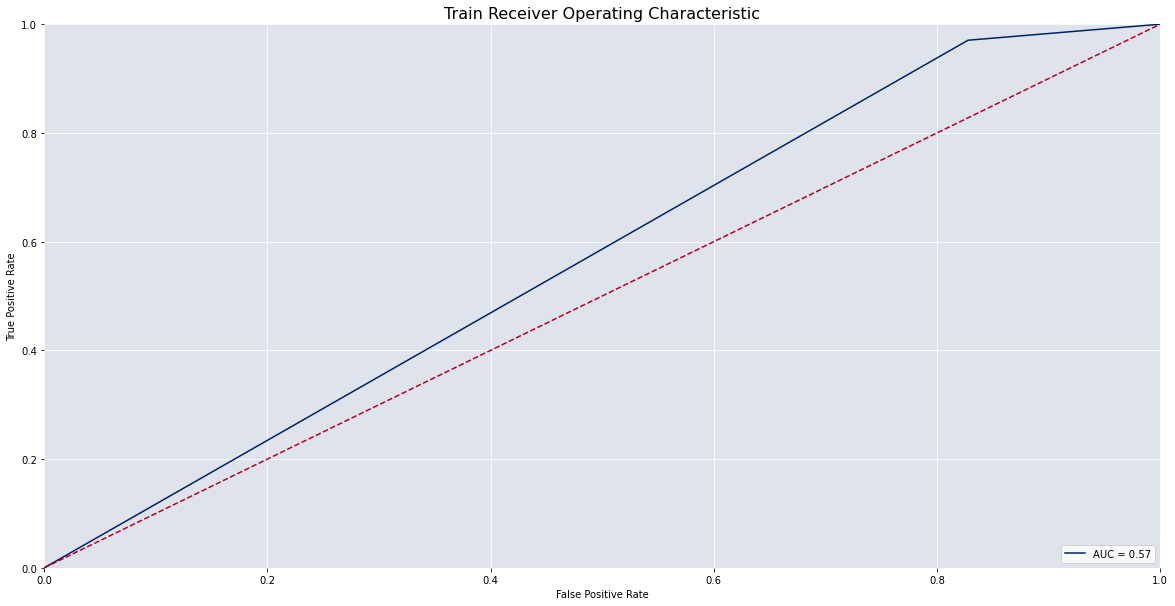

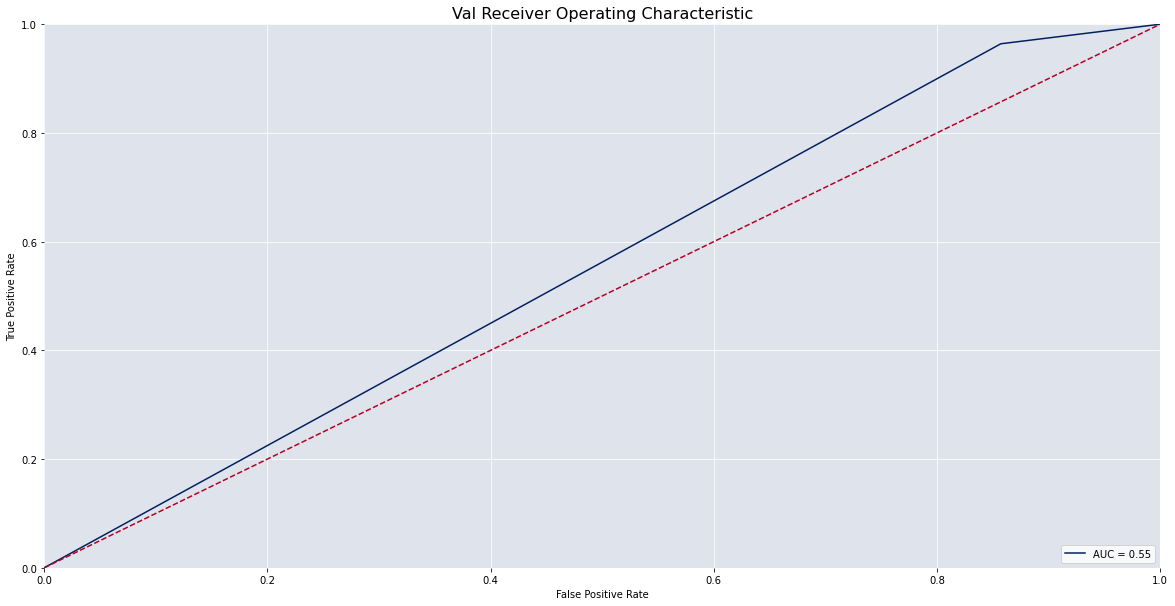

In [15]:
from ehr_functions.models import train_model

train_model('LogisticRegression', features, outcome, metrics=['BinaryClassification', 'ROCCurve'])

And we can try some other model types for comparison

Train
Accuracy: 81.41891891891892
AUC: 0.6553588322746318
              precision    recall  f1-score   support

         0.0       0.85      0.33      0.48       151
         1.0       0.81      0.98      0.89       441

    accuracy                           0.81       592
   macro avg       0.83      0.66      0.68       592
weighted avg       0.82      0.81      0.78       592


Validation
Accuracy: 77.3972602739726
AUC: 0.597039897039897
              precision    recall  f1-score   support

         0.0       0.56      0.26      0.35        35
         1.0       0.80      0.94      0.86       111

    accuracy                           0.77       146
   macro avg       0.68      0.60      0.61       146
weighted avg       0.74      0.77      0.74       146

Train AUC-ROC Curve
Val AUC-ROC Curve


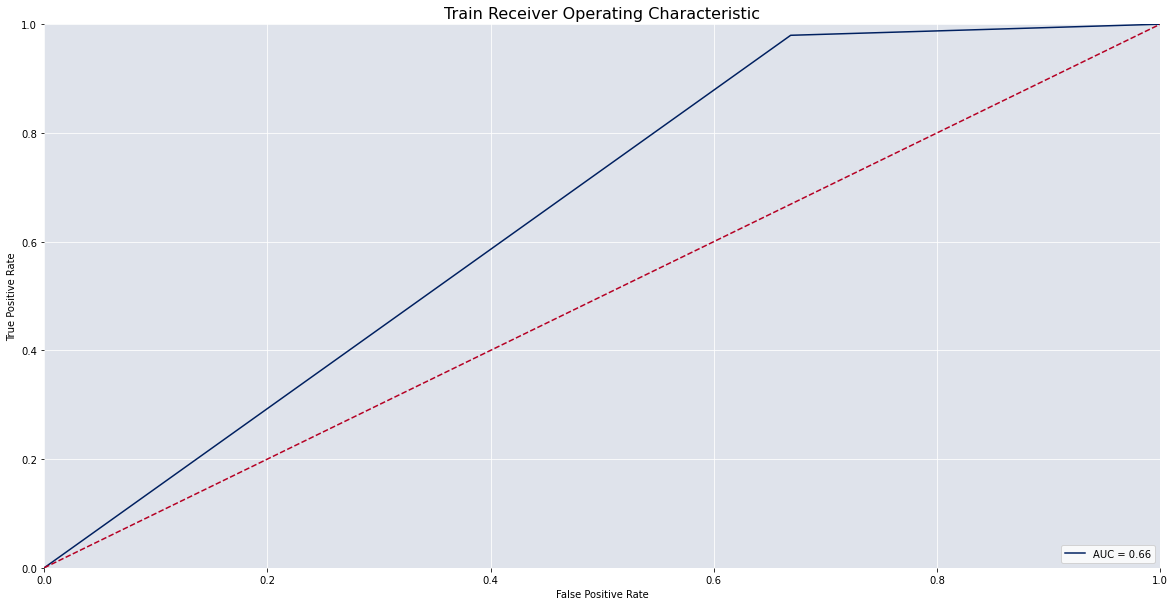

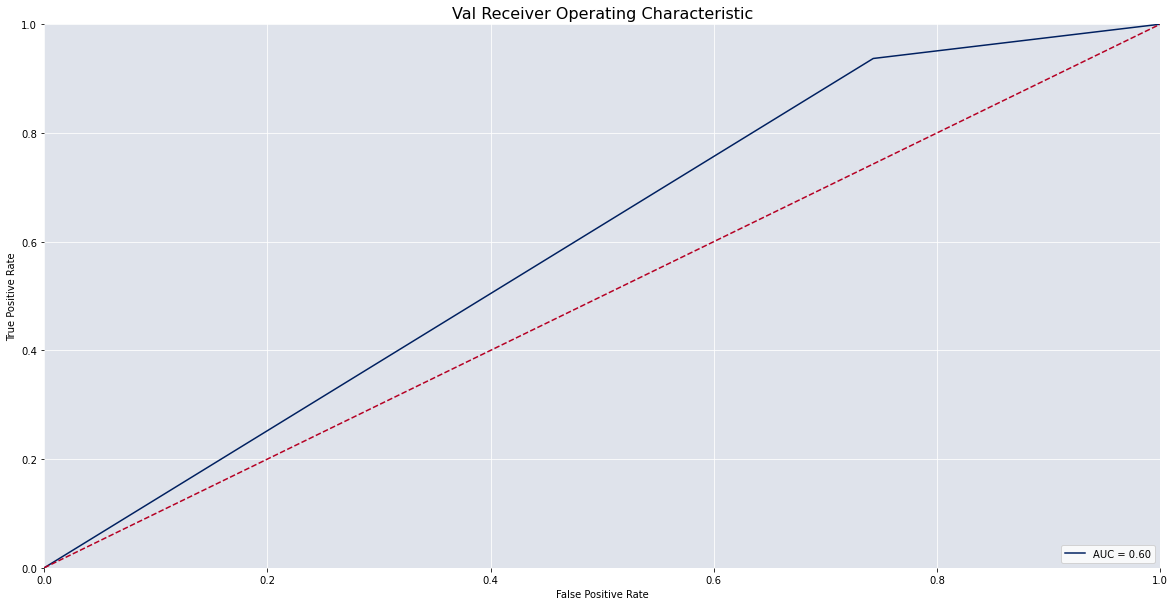

In [16]:
train_model('RandomForest', features, outcome, metrics=['BinaryClassification', 'ROCCurve'])

Train
Accuracy: 79.05405405405406
AUC: 0.6068237449505188
              precision    recall  f1-score   support

         0.0       0.81      0.23      0.36       151
         1.0       0.79      0.98      0.87       441

    accuracy                           0.79       592
   macro avg       0.80      0.61      0.62       592
weighted avg       0.80      0.79      0.74       592


Validation
Accuracy: 78.76712328767124
AUC: 0.5962676962676963
              precision    recall  f1-score   support

         0.0       0.67      0.23      0.34        35
         1.0       0.80      0.96      0.87       111

    accuracy                           0.79       146
   macro avg       0.73      0.60      0.61       146
weighted avg       0.77      0.79      0.75       146

Train AUC-ROC Curve
Val AUC-ROC Curve


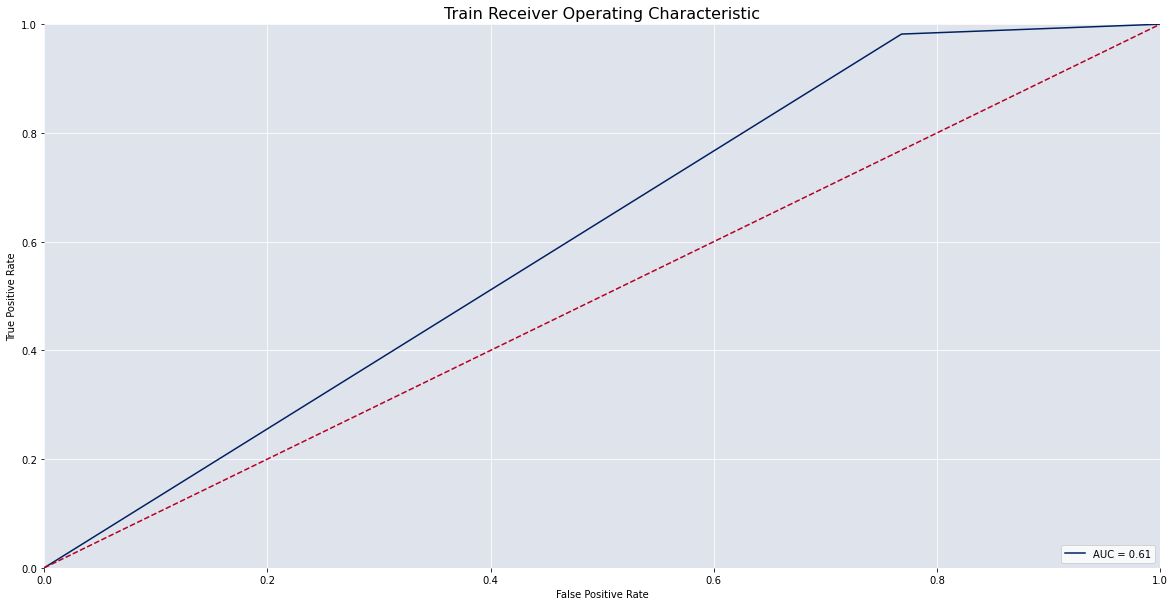

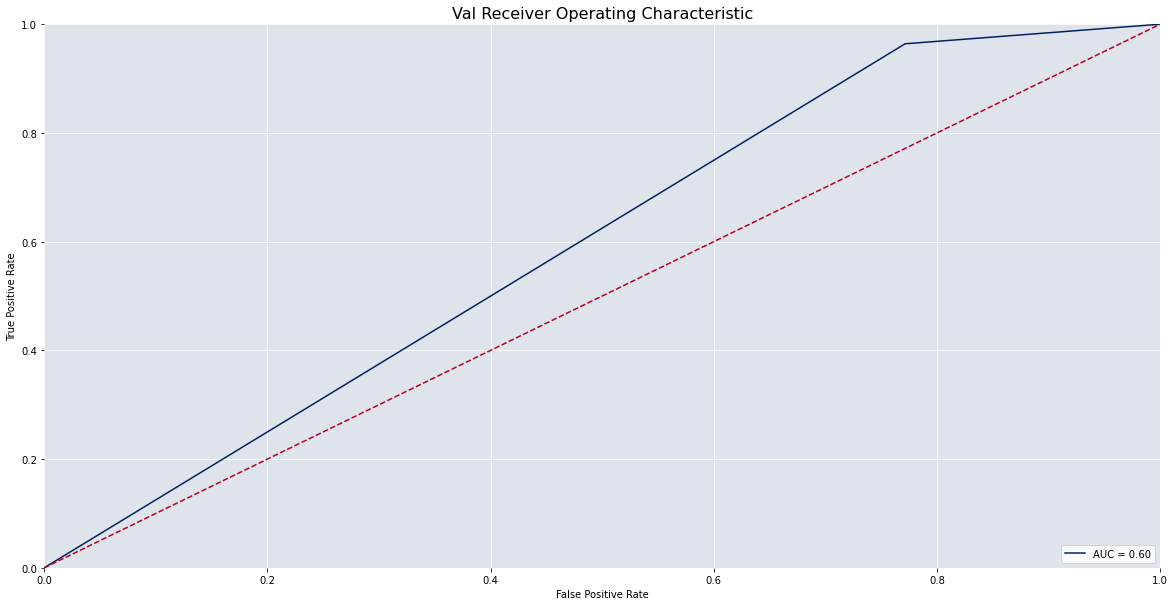

In [17]:
train_model('SVM', features, outcome, metrics=['BinaryClassification', 'ROCCurve'])